# Prerequisites

In [1]:
import numpy as np
import pandas as pd
import time
import csv
import matplotlib.pyplot as plt
from PIL import Image
from barbar import Bar

import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split

import sklearn.metrics as metrics
from sklearn.metrics import roc_auc_score

use_gpu = torch.cuda.is_available()
print(use_gpu)

True


# Pre-define Values

In [2]:
# Paths to the files with training, and validation sets.
# Each file contains pairs (path to image, output vector)
Traindata = pd.read_csv('./CheXpert-v1.0-small/train.csv')
Traindata = Traindata[Traindata['Path'].str.contains("frontal")] # use only frontal images
Traindata = Traindata[500:]
Traindata.to_csv('./CheXpert-v1.0-small/train_mod.csv', index = False)
print("Train data length:", len(Traindata))

Validdata = pd.read_csv('./CheXpert-v1.0-small/valid.csv')
Validdata = Validdata[Validdata['Path'].str.contains("frontal")] # use only frontal images
Validdata.to_csv('./CheXpert-v1.0-small/valid_mod.csv', index = False)
print("Valid data length:", len(Validdata))

Testdata = Traindata.head(500) # use first 500 training data as test data (obs ratio is almost same!)
Testdata.to_csv('./CheXpert-v1.0-small/test_mod.csv', index = False)
print("Test data length:", len(Testdata))

pathFileTrain = './CheXpert-v1.0-small/train_mod.csv'
pathFileValid = './CheXpert-v1.0-small/valid_mod.csv'
pathFileTest = './CheXpert-v1.0-small/test_mod.csv'

# Neural network parameters:
nnIsTrained = False     # pre-trained using ImageNet
nnClassCount = 14       # dimension of the output

# Training settings: batch size, maximum number of epochs
trBatchSize = 16
trMaxEpoch = 3

# Parameters related to image transforms: size of the down-scaled image, cropped image
imgtransResize = (320, 320)
imgtransCrop = 224

# Class names
class_names = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 
               'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 
               'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']

Train data length: 190527
Valid data length: 202
Test data length: 500


# Create a Dataset

In [3]:
class CheXpertDataSet(Dataset):
    def __init__(self, data_PATH, transform = None, policy = "ones"):
        """
        data_PATH: path to the file containing images with corresponding labels.
        transform: optional transform to be applied on a sample.
        Upolicy: name the policy with regard to the uncertain labels.
        """
        image_names = []
        labels = []

        with open(data_PATH, "r") as f:
            csvReader = csv.reader(f)
            next(csvReader, None) # skip the header
            for line in csvReader:
                image_name = line[0]
                label = line[5:]
                
                for i in range(14):
                    if label[i]:
                        a = float(label[i])
                        if a == 1:
                            label[i] = 1
                        elif a == -1:
                            if policy == "ones":
                                label[i] = 1
                            elif policy == "zeroes":
                                label[i] = 0
                            else:
                                label[i] = 0
                        else:
                            label[i] = 0
                    else:
                        label[i] = 0
                        
                image_names.append('./' + image_name)
                labels.append(label)

        self.image_names = image_names
        self.labels = labels
        self.transform = transform

    def __getitem__(self, index):
        """Take the index of item and returns the image and its labels"""
        image_name = self.image_names[index]
        image = Image.open(image_name).convert('RGB')
        label = self.labels[index]
        if self.transform is not None:
            image = self.transform(image)
        return image, torch.FloatTensor(label)

    def __len__(self):
        return len(self.image_names)

# Create DataLoaders

In [4]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]  # mean of ImageNet dataset(for normalization)
IMAGENET_STD = [0.229, 0.224, 0.225]   # std of ImageNet dataset(for normalization)

# Tranform data
normalize = transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
transformList = []

transformList.append(transforms.Resize((imgtransCrop, imgtransCrop))) # 224
# transformList.append(transforms.RandomResizedCrop(imgtransCrop))
# transformList.append(transforms.RandomHorizontalFlip())
transformList.append(transforms.ToTensor())
# transformList.append(normalize)
transformSequence = transforms.Compose(transformList)

# Load dataset
datasetTrain = CheXpertDataSet(pathFileTrain, transformSequence, policy = "ones")
print("Train data length:", len(datasetTrain))

datasetValid = CheXpertDataSet(pathFileValid, transformSequence)
print("Valid data length:", len(datasetValid))

datasetTest = CheXpertDataSet(pathFileTest, transformSequence, policy = "ones")
print("Test data length:", len(datasetTest))

# Use subset of datasetTrain
#print(len(datasetTrain))
#train_ratio = 1.0 # use 100% of original training dataset
#train_num = round(len(datasetTrain) * train_ratio)

#datasetTrain, datasetLeft = random_split(datasetTrain, [train_num, len(datasetTrain) - train_num])
#print(len(datasetTrain))
#print(len(datasetValid))
#datasetTest, datasetLeft = random_split(datasetLeft, [500, len(datasetLeft) - 500])
#print(len(datasetTest))

# Define DataLoaders
dataLoaderTrain = DataLoader(dataset = datasetTrain, batch_size = trBatchSize, 
                             shuffle = True, num_workers = 2, pin_memory = True)
dataLoaderVal = DataLoader(dataset = datasetValid, batch_size = trBatchSize, 
                           shuffle = False, num_workers = 2, pin_memory = True)
dataLoaderTest = DataLoader(dataset = datasetTest, num_workers = 2, pin_memory = True)

Train data length: 190527
Valid data length: 202
Test data length: 500


# Example Training Images

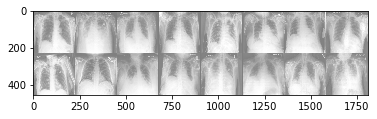

tensor([[0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1.],
        [0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0.],
        [0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
        [0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0.],
        [0

In [5]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(dataLoaderTrain)
images, labels = dataiter.next()

# Show images
imshow(torchvision.utils.make_grid(images))
print(labels)

# Create Train and Test Models

In [6]:
class CheXpertTrainer():

    def train(model, dataLoaderTrain, dataLoaderVal, nnClassCount, trMaxEpoch, checkpoint):
        optimizer = optim.Adam(model.parameters(), lr = 0.0001, # setting optimizer & scheduler
                               betas = (0.9, 0.999), eps = 1e-08, weight_decay = 0) 
        loss = torch.nn.BCELoss() # setting loss function
        
        if checkpoint != None and use_gpu: # loading checkpoint
            modelCheckpoint = torch.load(checkpoint)
            model.load_state_dict(modelCheckpoint['state_dict'])
            optimizer.load_state_dict(modelCheckpoint['optimizer'])
            
        # Train the network
        lossMIN = 100000
        train_start = []
        train_end = []
        for epochID in range(0, trMaxEpoch):
            train_start.append(time.time()) # training starts
            losst = CheXpertTrainer.epochTrain(model, dataLoaderTrain, optimizer, trMaxEpoch, nnClassCount, loss)
            train_end.append(time.time()) # training ends
            lossv = CheXpertTrainer.epochVal(model, dataLoaderVal, optimizer, trMaxEpoch, nnClassCount, loss)
            print("Training loss: {:.3f},".format(losst), "Valid loss: {:.3f}".format(lossv))
            
            if lossv < lossMIN:
                lossMIN = lossv
                torch.save({'epoch': epochID + 1, 'state_dict': model.state_dict(), 
                            'best_loss': lossMIN, 'optimizer' : optimizer.state_dict()}, 
                           'm-epoch_ALL' + str(epochID + 1) + '.pth.tar')
                print('Epoch ' + str(epochID + 1) + ' [save] loss = ' + str(lossv))
            else:
                print('Epoch ' + str(epochID + 1) + ' [----] loss = ' + str(lossv))
        
        train_time = np.array(train_end) - np.array(train_start)
        return train_time
       
        
    def epochTrain(model, dataLoaderTrain, optimizer, epochMax, classCount, loss):
        losstrain = 0
        model.train()

        for batchID, (varInput, target) in enumerate(Bar(dataLoaderTrain)):
            
            varTarget = target.cuda(non_blocking = True)
            varOutput = model(varInput)
            lossvalue = loss(varOutput, varTarget)
                       
            optimizer.zero_grad()
            lossvalue.backward()
            optimizer.step()
            
            losstrain += lossvalue.item()
            
        return losstrain / len(dataLoaderTrain)
    
    
    def epochVal(model, dataLoaderVal, optimizer, epochMax, classCount, loss):
        model.eval()
        lossVal = 0

        with torch.no_grad():
            for i, (varInput, target) in enumerate(dataLoaderVal):
                
                target = target.cuda(non_blocking = True)
                varOutput = model(varInput)
                
                lossVal += loss(varOutput, target)
                
        return lossVal / len(dataLoaderVal)

    
    def computeAUROC(dataGT, dataPRED, classCount):
        # Computes area under ROC curve 
        # dataGT: ground truth data
        # dataPRED: predicted data
        outAUROC = []
        datanpGT = dataGT.cpu().numpy()
        datanpPRED = dataPRED.cpu().numpy()
        
        for i in range(classCount):
            try:
                outAUROC.append(roc_auc_score(datanpGT[:, i], datanpPRED[:, i]))
            except ValueError:
                pass
        return outAUROC
    
    
    def test(model, dataLoaderTest, nnClassCount, checkpoint, class_names):
        cudnn.benchmark = True
        
        if checkpoint != None and use_gpu:
            modelCheckpoint = torch.load(checkpoint)
            model.load_state_dict(modelCheckpoint['state_dict'])

        if use_gpu:
            outGT = torch.FloatTensor().cuda()
            outPRED = torch.FloatTensor().cuda()
        else:
            outGT = torch.FloatTensor()
            outPRED = torch.FloatTensor()
       
        model.eval()
        
        with torch.no_grad():
            for i, (input, target) in enumerate(dataLoaderTest):

                target = target.cuda()
                outGT = torch.cat((outGT, target), 0).cuda()

                bs, c, h, w = input.size()
                varInput = input.view(-1, c, h, w)
            
                out = model(varInput)
                outPRED = torch.cat((outPRED, out), 0)
        aurocIndividual = CheXpertTrainer.computeAUROC(outGT, outPRED, nnClassCount)
        aurocMean = np.array(aurocIndividual).mean()
        print('AUROC mean ', aurocMean)
        
        for i in range (0, len(aurocIndividual)):
            print(class_names[i], ' ', aurocIndividual[i])
        
        return outGT, outPRED

# Define and Train the Model

In [7]:
class DenseNet121(nn.Module):
    """Model modified.
    The architecture of our model is the same as standard DenseNet121
    except the classifier layer which has an additional sigmoid function.
    """
    def __init__(self, out_size):
        super(DenseNet121, self).__init__()
        self.densenet121 = torchvision.models.densenet121(pretrained = False)
        num_ftrs = self.densenet121.classifier.in_features
        self.densenet121.classifier = nn.Sequential(
            nn.Linear(num_ftrs, out_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.densenet121(x)
        return x

In [8]:
# Initialize and load the model
model = DenseNet121(nnClassCount).cuda()
model = torch.nn.DataParallel(model).cuda()

In [9]:
train_valid_start = time.time()
train_time = CheXpertTrainer.train(model, dataLoaderTrain, dataLoaderVal, nnClassCount, trMaxEpoch, checkpoint = None)
train_valid_end = time.time()
print("Model trained")

190527/190527: [===============================>] - ETA 1.2sssss
Training loss: 0.380, Valid loss: 0.385
Epoch 1 [save] loss = tensor(0.3849, device='cuda:0')
190527/190527: [===============================>] - ETA 0.7ssss
Training loss: 0.363, Valid loss: 0.415
Epoch 2 [----] loss = tensor(0.4151, device='cuda:0')
190527/190527: [===============================>] - ETA 0.6ssss
Training loss: 0.356, Valid loss: 0.365
Epoch 3 [save] loss = tensor(0.3651, device='cuda:0')
Model trained


# Test and ROC Curves

In [10]:
outGT, outPRED = CheXpertTrainer.test(model, dataLoaderTest, nnClassCount, "m-epoch2.pth.tar", class_names)

AUROC mean  0.7934111552310876
No Finding   0.872480936819172
Enlarged Cardiomediastinum   0.7016579775491992
Cardiomegaly   0.8718543729372937
Lung Opacity   0.7249246593291405
Lung Lesion   0.7160012982797793
Edema   0.8421357496017708
Consolidation   0.7673267326732673
Pneumonia   0.7475502408237834
Atelectasis   0.7485402259909524
Pneumothorax   0.8635390305625851
Pleural Effusion   0.8884
Pleural Other   0.7894487442742063
Fracture   0.7430162043940749
Support Devices   0.8308800000000001


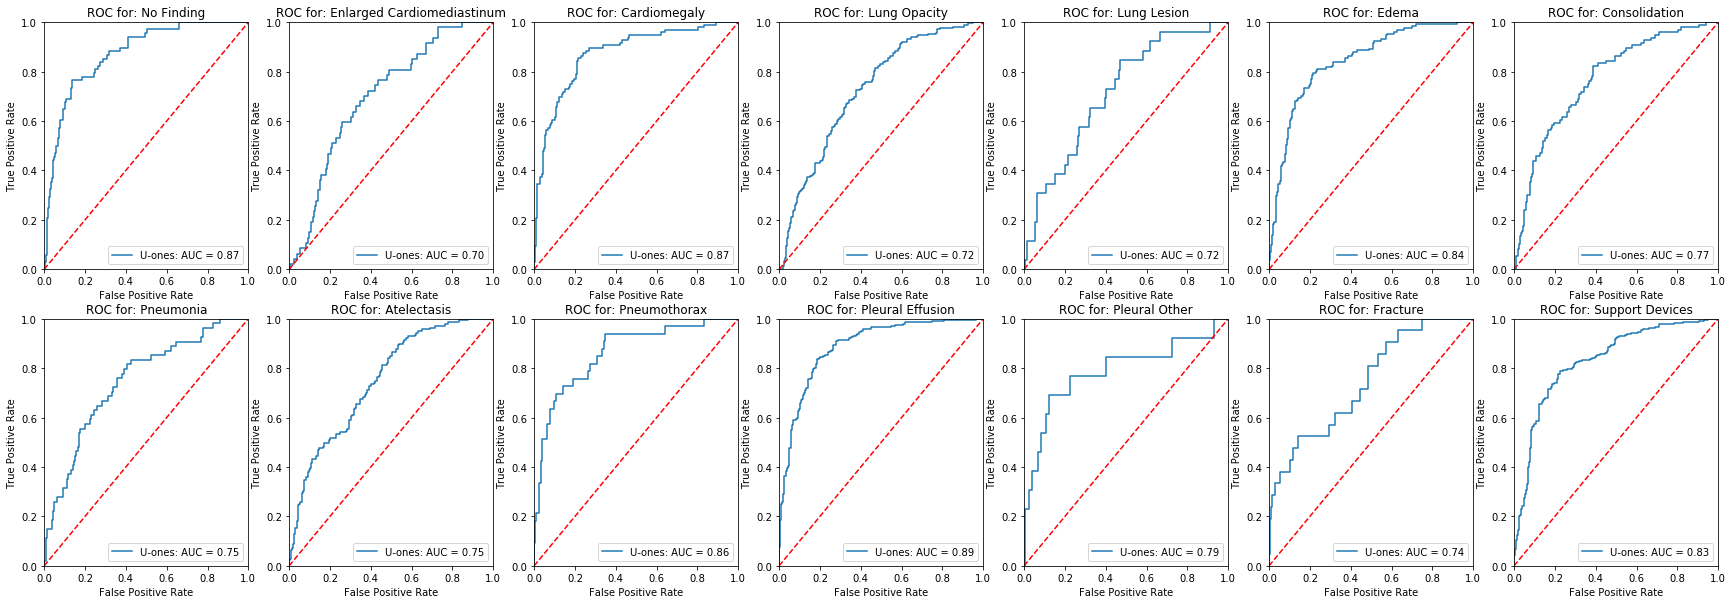

In [12]:
for i in range(nnClassCount):
    fpr, tpr, threshold = metrics.roc_curve(outGT.cpu()[:,i], outPRED.cpu()[:,i])
    roc_auc = metrics.auc(fpr, tpr)
    f = plt.subplot(2, 7, i+1)

    plt.title('ROC for: ' + class_names[i])
    plt.plot(fpr, tpr, label = 'U-ones: AUC = %0.2f' % roc_auc)

    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

fig_size = plt.rcParams["figure.figsize"]
plt.rcParams["figure.figsize"] = (30, 10)

plt.savefig("ROC.png", dpi = 1000)
plt.show()

# Computational Stats

In [13]:
# Single GPU(TITAN RTX GPU) usage was about 50% while training
print(train_time.round(0), '/seconds') # took about 3.5 min for one epoch training(35 min for whole dataset)
print(round(train_valid_end - train_valid_start), 'seconds') # took about 10 min for whole training(100 min for whole training)

[3149. 3020. 3454.] /seconds
9627 seconds
